# Test basic framework functionality

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [26]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import plot
import data_utils
import krige_tools
import fields
import cov_model
import cokrige

## Load and view data

In [4]:
# read 5-degree monthly data and subset to US for faster testing
time = "2019-07-01"
ds = xr.open_dataset("../data/exp_pro/OCO2_5deg_monthly.nc")

ds

<xarray.Dataset>
Dimensions:   (lat: 35, lon: 72, time: 75)
Coordinates:
  * lon       (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat       (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 67.5 72.5 77.5 82.5
  * time      (time) datetime64[ns] 2014-09-01 2014-10-01 ... 2020-11-01
Data variables:
    sif       (lon, lat, time) float32 ...
    sif_var   (lon, lat, time) float32 ...
    xco2      (lon, lat, time) float32 ...
    xco2_var  (lon, lat, time) float32 ...

## Setup fields and fit empirical kernels (params from variogram model)

In [5]:
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]
Z = fields.MultiField(ds_xco2, ds_sif, "2019-07-01", timedelta=-2, center=True)

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [28]:
from scipy.interpolate import griddata, interp2d

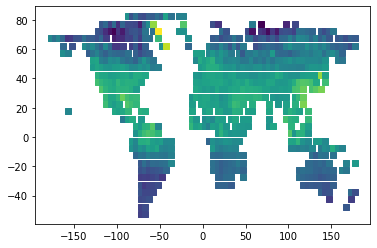

In [7]:
plt.scatter(Z.field_1.coords[:,1], Z.field_1.coords[:,0], c=Z.field_1.mean, marker="s")

In [32]:
surf = griddata(Z.field_1.coords, Z.field_1.mean, pred_loc, method="nearest")
surf.shape

(607,)

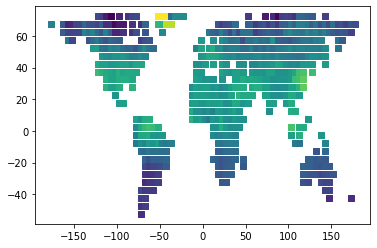

In [33]:
plt.scatter(pred_loc[:,1], pred_loc[:,0], c=surf, marker="s")

In [12]:
"""
TODO: 
- look into how bin_edges are used in variogram fitting
- add option to set individual parameters manually
- don't spend too much time on the variogram approach
"""
bin_edges = np.arange(100)
k1 = cov_model.Matern()
k2 = cov_model.Matern()
model = cov_model.BivariateMatern(Z, k1, k2)._empirical_kernels(bin_edges)
predictor = cokrige.Cokrige(Z, model, fast_dist=True)

In [13]:
model.get_params()

{'sigma_11': 2.5384447080202546,
 'nu_11': 23.646878317472844,
 'len_scale_11': 19.466791512062837,
 'nugget_11': 0.0010139825795458068,
 'sigep_11': 1.075824,
 'nu_12': 26.74893915873642,
 'len_scale_12': 17.574575154581222,
 'rho': 0.25344262655641053,
 'sigma_22': 0.20314013805122802,
 'nu_22': 29.851,
 'len_scale_22': 15.682358797099607,
 'nugget_22': 0.0002793636387723716,
 'sigep_22': 0.20755595}

## Cokriging over XCO2 grid

In [18]:
pred_loc = krige_tools.land_grid(res=5, lat_lwr=-60, lat_upr=75)
pred, pred_err = predictor(pred_loc)

In [27]:
ds_pred = data_utils.to_xarray(pred_loc, pred=pred, pred_err=pred_err)
ds_pred

<xarray.Dataset>
Dimensions:   (lat: 26, lon: 69)
Coordinates:
  * lon       (lon) float64 -177.5 -162.5 -157.5 -152.5 ... 167.5 172.5 177.5
  * lat       (lat) float64 -52.5 -47.5 -42.5 -37.5 ... 57.5 62.5 67.5 72.5
Data variables:
    pred      (lon, lat) float64 nan nan nan nan nan ... nan nan nan 314.4 nan
    pred_err  (lon, lat) float64 nan nan nan nan nan ... nan nan nan 0.9499 nan

## Plot data and results in a grid

(<GeoAxesSubplot:title={'center':'XCO$_2$: cokriging standard error'}, xlabel='lon', ylabel='lat'>,
 None)

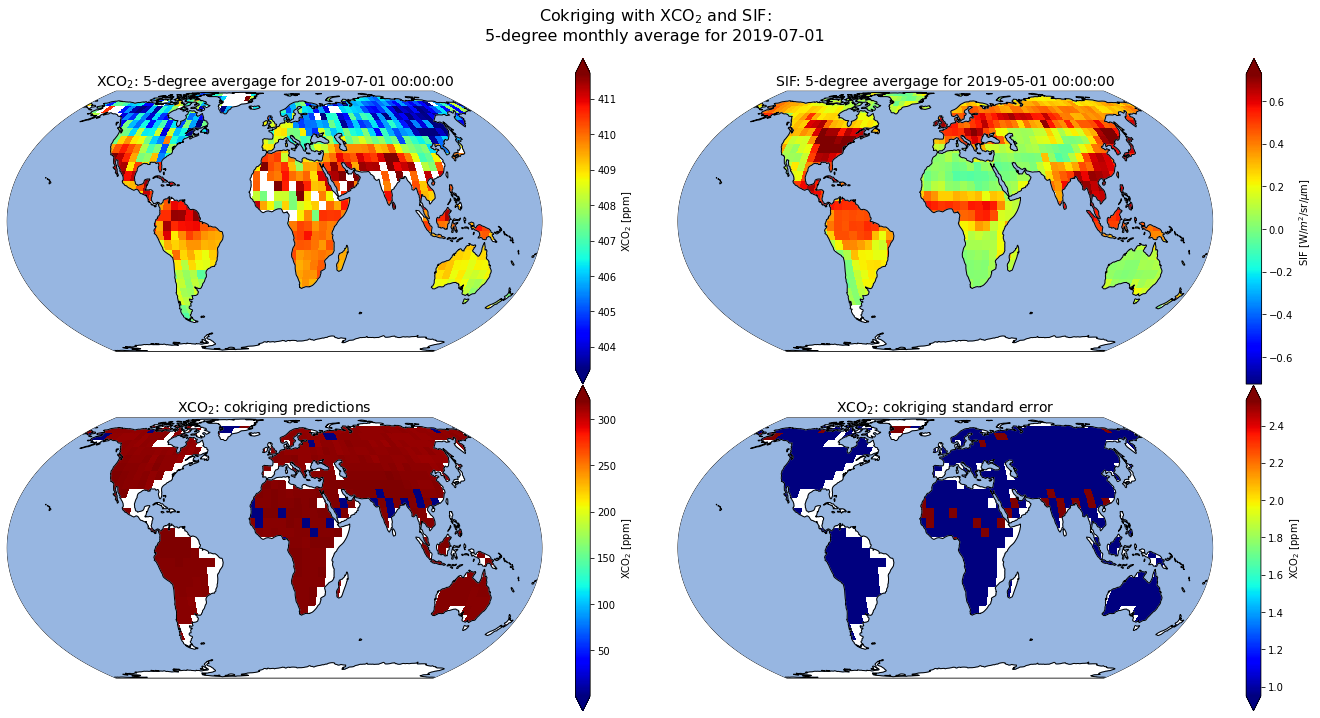

In [20]:
## TODO: find a nice way to display model parameter values in plot

fig = plt.figure(figsize=(24, 12))
gs = fig.add_gridspec(100, 100)


# fig.subplots_adjust(top=0.8)
fig.suptitle(
    "Cokriging with XCO$_2$ and SIF:\n"
    f"5-degree monthly average for {time}\n",
    size=16, y=0.94
)

# Input data
ax1 = fig.add_subplot(gs[0:50, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[0:50, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    ds.xco2.sel(time=time),
    title=f"XCO$_2$: 5-degree avergage for {Z.field_1.timestamp}",
    ax=ax1,
    cbar_kwargs={"label": "XCO$_2$ [ppm]"}
)
plot.plot_da(
    ds.sif.sel(time=time),
    title=f"SIF: 5-degree avergage for {Z.field_2.timestamp}",
    ax=ax2,
    cbar_kwargs={"label": "SIF [W/$m^2$/sr/$\mu$m]"}
)

# Predictions and standard error
ax3 = fig.add_subplot(gs[50:, 0:50], projection=ccrs.EqualEarth())
ax4 = fig.add_subplot(gs[50:, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    ds_pred.pred,
    title="XCO$_2$: cokriging predictions",
    ax=ax3,
    cbar_kwargs={"label": "XCO$_2$ [ppm]"}
)
plot.plot_da(
    ds_pred.pred_err,
    title="XCO$_2$: cokriging standard error",
    ax=ax4,
    cbar_kwargs={"label": "XCO$_2$ [ppm]"}
)

# fig.savefig("../plots/cokriging_demo.png");

In [17]:
param_values = [f"{key}: {np.round(value, 3)},\n" for key, value in model.get_params().items()]
print("Parameter values:\n" + "".join(param_values))

Parameter values:
sigma_11: 2.538,
nu_11: 23.647,
len_scale_11: 19.467,
nugget_11: 0.001,
sigep_11: 1.0759999752044678,
nu_12: 26.749,
len_scale_12: 17.575,
rho: 0.253,
sigma_22: 0.203,
nu_22: 29.851,
len_scale_22: 15.682,
nugget_22: 0.0,
sigep_22: 0.20800000429153442,

